In [49]:
#encoding=utf-8
import jieba
import collections
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from math import log10
import matplotlib.font_manager as fm

jieba.set_dictionary('./dict.txt')
warnings.filterwarnings('ignore')

In [3]:
def preprocessing(articles):
    dataset = list()
    for article in articles[:1000]: # 先少一點
        sentences = article[:-1].split('\t') # sentences: list
        for i in range(len(sentences)): # iterate 時不會直接改到原本容器, 所以要用 index traverse
            sentences[i] = re.sub(r'\W+', "", sentences[i])
        parsed_sentences = list()
        for sentence in sentences:
            words = list(jieba.cut(sentence, cut_all=False)) # 一句一句切
            parsed_sentences.append(words) # 切過的句子組合成文章
        # print(parsed_sentences)
        dataset.append(parsed_sentences) # 文章組合成檔案集 # parsed_sentences = article
    # print(dataset)
    return list(dataset)

In [4]:
def tf(article): # t: 詞
    word_statistics_in_article = collections.Counter()
    for sentence in article:
        word_statistics_in_article += collections.Counter(sentence)
    # print(word_statistics_in_article)
    ### 計算 tf
    total = sum(word_statistics_in_article.values(), 0.0)
    word_tf_in_article = {key: round((val/total), 2) for key, val in sorted(word_statistics_in_article.items(), key=lambda x: x[1], reverse=True)}
    # print(pd.DataFrame(list(word_tf_in_article.items()), columns=['word', 'tf'])) # DataFrame 好看但我不太會用
    return word_tf_in_article

In [5]:
def idf(tf_per_article_table, q): # terms: list of all words
    word_appear_count = collections.Counter()
    for i in range(len(tf_per_article_table)):
        word_appear_count += collections.Counter({key: 1 for key in tf_per_article_table[i].keys()})
    
    idf_table = {word: round(log10(q / count), 3) for word, count in word_appear_count.items()}
    return idf_table

In [40]:
from matplotlib.font_manager import findfont, FontProperties
findfont(FontProperties(family=FontProperties().get_family()))

'/Users/jonahtsao/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [7]:
def word_tf_in_dataset(dataset):
    all_words_count = collections.Counter()
    for article in dataset:
        for sentence in article:
            all_words_count += collections.Counter(sentence)
    total = sum(all_words_count.values(), 0.0)
    all_words_tf = {key: round((val/total), 3) for key, val in sorted(all_words_count.items(), key=lambda x: x[1], reverse=True)}
    return all_words_tf

In [8]:
def tf_idf(tf_t_d, idf_t_D):
    ### To Do
    # print(idf_t_D)
    table = dict()
    for t, tf in tf_t_d.items():
        # print(t, tf, idf_t_D[t])
        table[t] = round((tf * idf_t_D[t]), 3)
    # print(table)
    return {key: val for key, val in sorted(table.items(), key=lambda x: x[1], reverse=True)}

In [70]:
def rank_100(tf_idf_table):
    skip_flag = {key: False for key in tf_idf_table.keys()}
    rank_100 = {'a': 0.0}
    min_in_rank = ('a', 0.0)
    idx = 0
    while True:
        stop_flag = True
        for i in range(len(tf_idf_table)):
            if idx >= len(tf_idf_table[i].items()): # 第 i 篇文章已經掃完了, 直接往下一篇
                continue
            if skip_flag[i] != True: # 第 i 篇文章還沒掃完, 且不 skip
                word, weight = tuple(tf_idf_table[i].items())[idx] # list(tf_idf_table[i].items())[idx] 第 i 個文章中的 第 idx 大的
                if weight > min_in_rank[1]:  # if 文章 i 第一高權重的值 > rank 100 中最小值
                    rank_100[ word ] = weight # 加進新血
                    if len(rank_100) > 100: # 若列表超過 100, 該踢人 (ps: 還沒滿的話不排也沒差)
                        rank_100.pop(min_in_rank[0]) # 殺掉最小
                        new_rank_list = sorted(rank_100.items(), key=lambda x: x[1], reverse=True) # 重新排序後的列表
                        min_in_rank = new_rank_list[-1] # 更新最小
                        rank_100 = {key: val for key, val in new_rank_list} # 用重排後的 list 更新 rank_100
                    
                    stop_flag = False
                else:
                    skip_flag[i] = True
                
        if stop_flag == True: break # 都沒更新 === skip_flag 全部變 True 了, 跳出迴圈
        idx += 1
    # print(rank_100, len(rank_100))
    return list(rank_100.items())

In [65]:
def draw(rank_100, filename, row_labels, col_labels):
    # print(rank_100)
    x = [item[0] for item in rank_100]
    y = [item[1] for item in rank_100]
    fontPath = r'/Users/jonahtsao/Desktop/七年/tools/NotoSansCJK-TC/NotoSansCJKtc-Light.otf'
    font = fm.FontProperties(fname=fontPath, size=10)
    
    fig = plt.figure(figsize=(20,20))
    plt.bar(x, y)
    plt.xticks(range(len(x)), x, fontproperties=font)
    plt.title(filename)
    plt.xlabel(row_labels)
    plt.ylabel(col_labels)
    
    plt.savefig("./" + filename + ".png")
    return None

[('廠廠', 2.25), ('林依晨', 0.99), ('憂傷', 0.99), ('胖胖', 0.99), ('希拉蕊', 0.99), ('MakeAmericaGreatAgain', 0.99), ('黎明', 0.9), ('漫畫', 0.891), ('恭喜', 0.891), ('加油', 0.891), ('金剛', 0.87), ('雷電', 0.87), ('醫生', 0.81), ('盡頭', 0.783), ('錢', 0.772), ('感謝', 0.759), ('Snowbaby', 0.75), ('分手', 0.75), ('咕咕', 0.75), ('瑞雪', 0.75), ('姆咪', 0.711), ('高中', 0.681), ('核核', 0.66), ('以色列', 0.66), ('雙層', 0.66), ('演', 0.631), ('工具人', 0.631), ('金牌', 0.63), ('通知', 0.6), ('回收', 0.6), ('階段', 0.6), ('國考', 0.6), ('開罐器', 0.6), ('前衝', 0.6), ('張老師', 0.6), ('雞舞', 0.6), ('科學園區', 0.6), ('買裝', 0.6), ('牛舞', 0.6), ('豬舞', 0.6), ('新年', 0.575), ('奮起湖', 0.57), ('詠春', 0.54), ('擠', 0.54), ('汐止人', 0.54), ('智商', 0.54), ('ABS', 0.54), ('新竹', 0.54), ('維修', 0.54), ('8591', 0.54), ('隻', 0.539), ('系列', 0.528), ('青年', 0.513), ('3D', 0.51), ('當人', 0.51), ('婚姻', 0.51), ('打打', 0.51), ('莊心妍', 0.51), ('母系', 0.51), ('志明', 0.51), ('賄選', 0.51), ('下雨天', 0.51), ('哇操', 0.51), ('客家語', 0.51), ('催眠術', 0.51), ('學士', 0.51), ('控制', 0.51), ('甩掉', 0.51), ('中山', 0

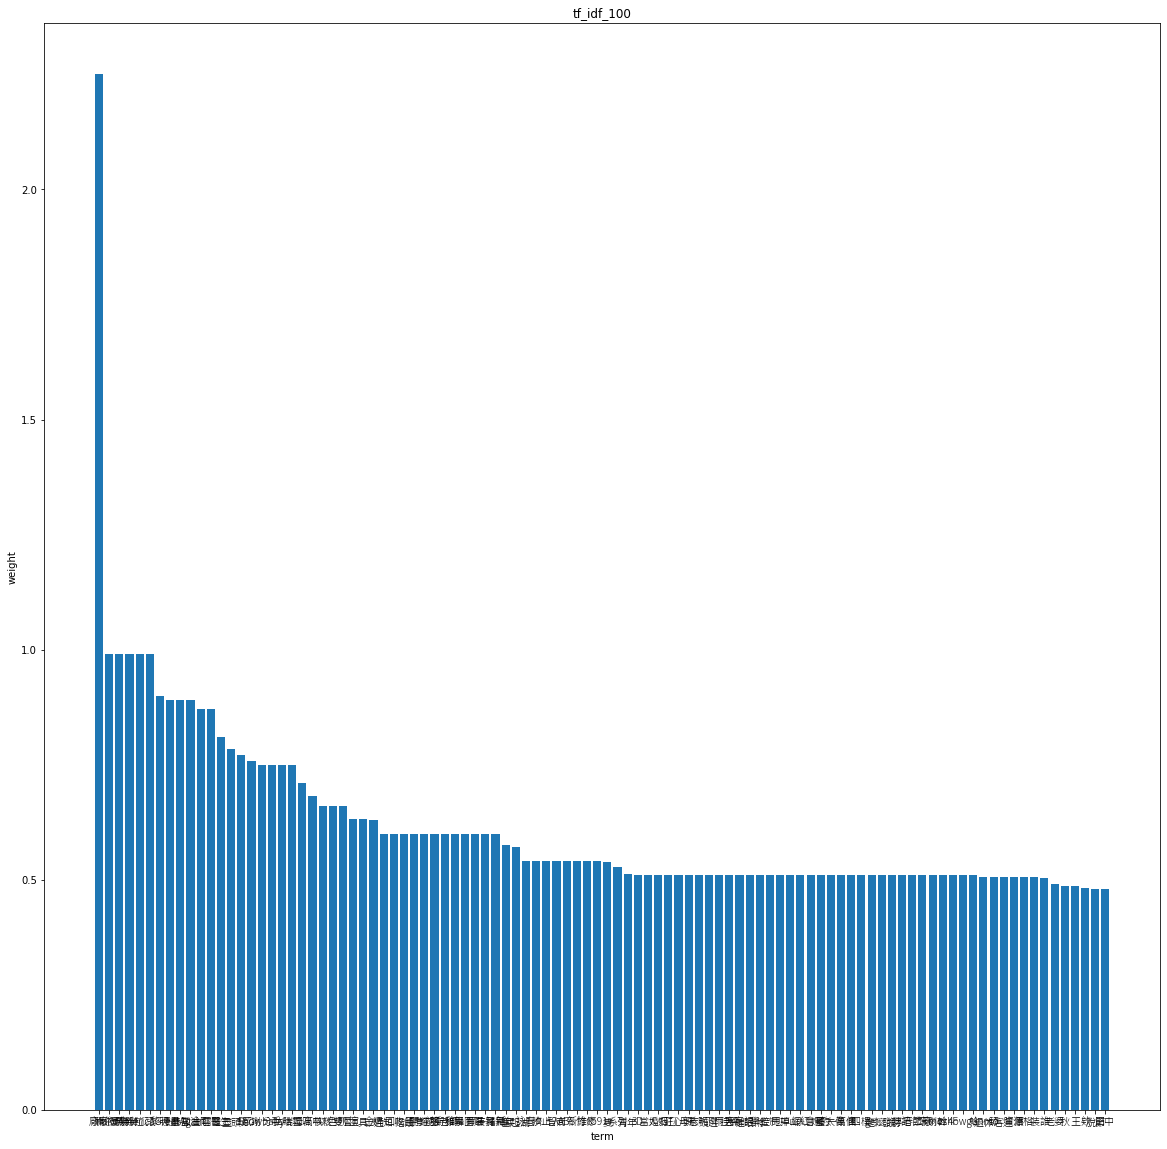

In [71]:
def main():
    file = open("./hw1-dataset.txt", mode='r')
    articles = file.readlines()
    dataset = preprocessing(articles)
    
    ### 統計高頻
    tf_whole_dataset_table = word_tf_in_dataset(dataset) # 高頻詞(已排序)
    # print(list(tf_whole_dataset_table.items())[:100])
    tf_100 = list(tf_whole_dataset_table.items())[:100]
    
    ### 建 tf table
    tf_per_article_table = dict()
    for article_no in range(len(dataset)):
        tf_per_article_table[article_no] = tf(dataset[article_no])
    # print(tf_per_article_table) # 取值: tf_per_article_table[article_no][t] = tf(t, d)
    
    ### 建 idf table
    idf_table = idf(tf_per_article_table, len(dataset))
    # print(idf_table)
    
    ### 統計 tf-idf 高
    tf_idf_table = dict()
    for article_no in range(len(dataset)):
        tf_idf_table[article_no] = tf_idf(tf_per_article_table[article_no], idf_table)
    # print(tf_idf_table)
    tf_idf_100 = rank_100(tf_idf_table)
    
    ### 畫圖
    draw(tf_100, "tf_100", "term", "frequency")
    draw(tf_idf_100, "tf_idf_100", "term", "weight")
    
    file.close()
main()